<p style="text-align: center;"><span style="color:#262626"><span style="font-size:42px"><span style="font-family:lato,sans-serif"><span style="font-weight:bold">
SCF Workshop
</span></span></span></span></p>

<p style="text-align: left;"><span style="color:#262626"><span style="font-size:18px"><span style="font-family:lato,sans-serif">
By: Lucas Aebersold 
</span></span></span></p>
<p style="text-align: left;"><span style="color:#262626"><span style="font-size:18px"><span style="font-family:lato,sans-serif">
Summer 2019
</span></span></span></p>
<p style="text-align: justify;"><span style="color:#262626"><span style="font-size:16px"><span style="font-family:lato,sans-serif">
In this workshop, we will be creating our very own Hartree Fock code! Now, when someone asks if you remember making your first HF code, you won't actually be lying!! Let's begin!
</span></span></span></p>

***

This code and discussion are based out of *Modern Quantum Chemistry*, Introduction to Advanced Electronic Structure Theory. by Szabo and Ostlund[1]. If you don't have it, consider buying it! Order it on [Amazon](https://www.amazon.com/Modern-Quantum-Chemistry-Introduction-Electronic/dp/0486691861/ref=sr_1_5?ie=UTF8&qid=1526232742&sr=8-5&keywords=quantum+chemistry&dpID=41mbqZjAm6L&preST=_SY291_BO1,204,203,200_QL40_&dpSrc=srch), it's like \\$20  new, and like \\$5 used.

You can find pdf copies too, I can show you how just ask me. 


This workshop tutorial is also based on some HF tutorials, created by the Psi4 developers, which are apart of an online repository. I suggest you check it out, and later in the tutorials, we will be using Psi4 for python 
[Psi4numpy](https://github.com/psi4/psi4numpy)

Lastly, you can also check out some notes from the 
[Sherrill group](http://vergil.chemistry.gatech.edu/notes/)
### References
1. A. Szabo and N. S. Ostlund, *Modern Quantum Chemistry*, Introduction to Advanced Electronic Structure Theory. Courier Corporation, 1996.

## The Code
Let's import the libraries we need

`Note:` I do the `*` import for numpy, which imports everything and can be called directly. In most cases, this isn't a good programming practice, but in my (our) case we are always using numpy. Also, I personally hate code that has all the `np.cos`, `np.pi`, `np.exp`, etc., it looks very unnatural and unnecessarily convoluted. But do things as you see fit and make sure the code is readable. 


**With that out of the way let's begin!!!**

We will need the `numpy` and `scipy` libraries 

In [1]:
from numpy import *
from scipy.linalg import eigh, eig, inv
from scipy.special import erf
from scipy.constants import physical_constants
import os
# conversions: atomic units to eV and bohr (a0) to angstrom
au2eV = physical_constants['Hartree energy in eV'][0]
bohr2ang = physical_constants['Bohr radius'][0]*1e10

These are just printing functions I've defined for later use and you don't need to worry about what they're doing
for the sake of understanding this tutorial. Their purpose is just to print out results in a clean and readable fashion

In [2]:
bohr2ang = 0.529177
# routines to print out matrices in a nice readable format
def print_matrix(mat, header, print_file=None):

    cols = mat.shape[0]
    rows = mat.shape[1]

    str_mat ='{:^{width}}\n'.format(header, width=rows*10)
    for i in range(cols):
        str_mat += '{}\n'.format(' '.join('{:> .6f}'.format(x) for x in mat[i,:]))
    print(str_mat, file=print_file)
    
def print_matrix_center(mat, header, print_file=None):

    cols = mat.shape[0]
    rows = mat.shape[1]

    str_mat ='{:^{width}}\n'.format(header, width=rows*20+9)
    for i in range(cols):
        str_mat += '{:^{width}}\n'.format(' '.join('{:> .6f}'.format(x) for x in mat[i,:]), width=rows*20+9)
        
    print(str_mat, file=print_file)
    
def print_matrices(mat, mat2, header, print_file=None):

    cols = mat.shape[0]
    rows = mat.shape[1]

    str_mat ='{:^{width}}'.format(header[0], width=rows*9)
    str_mat += '{:^{width}}'.format(' ', width=9)
    str_mat +='{:^{width}}\n'.format(header[1], width=rows*10)
    for i in range(cols):
        str_mat += '{}'.format(' '.join('{:> 8.6f}'.format(x) for x in mat[i,:]))
        str_mat += '{:^{width}}'.format(' ', width=9)
        str_mat += '{}\n'.format(' '.join('{:> 8.6f}'.format(x) for x in mat2[i,:]))
        
    print(str_mat, file=print_file)
    
# prints vector occupation and orbital energies
def print_diag(mat, print_file=None):
    diag_vals = mat.diagonal()
    nel = 2
    str_mat ='{:^80}\n'.format('{:^{width}}         Energy'.format('MO', width=10))
    for i in range(len(diag_vals)):
        str_mat += '{:^80}\n'.format('Vector {}  Occ={}  {: .6f}'.format(i+1, nel, diag_vals[i]))
        nel -= 2 
    print(str_mat, file=print_file)
    
# prints all matrices during scf cycle
def verbose_iter_print(print_file):
    print('\n{:*^80}\n'.format(" Iteration {:2} ".format(scf_iter + 1)), file=print_file)
    print_matrices(F, Fprime, ['F matrix', "F' matrix"], print_file=print_file)
    print_matrices(C, Cprime, ['C matrix', "C' matrix"], print_file=print_file)
    print_matrix_center(P, 'P matrix', print_file=print_file)    
    print('{:<20} = {: .11f}'.format('Electronic Energy', E), file=print_file)
    print('{:<20} = {: .11f}'.format('Total Energy', ET), file=print_file)
    print('Delta (Convergence of the density matrix) = {:.6e}'.format(delta), file=print_file)
    
def print_error_quit():
    print('FATAL ERROR\nGROSSE FEHLER\nCALCULATION DID NOT CONVERGE!', file=f)
    print_diag(Eocc, print_file=f)
    print('{:<18} = {: .11f}'.format('Electronic Energy', E), file=f)
    print('{:<18} = {: .11f}'.format('Total Energy', ET), file=f)
    
def print_convergence_success(Eocc, orthog='canonical'):
    print('{:^80}\n{:^80}'.format('CALCULATION CONVERGED!!!!', 'OMG!!!!!'), file=f)
    print('{:_^80}'.format(' Final Values (atomic units) '), file=f)
    if orthog == 'canonical':
        print_diag(Eocc, print_file=f)
    elif orthog == 'symmetric':
        Eocc = Eocc*eye(2)
        print_diag(Eocc, print_file=f)
        
    print('{:<18} = {: .11f}'.format('Electronic Energy', E), file=f)
    print('{:<18} = {: .11f}'.format('Total Energy', ET), file=f)

I've also predefined some other functions which are included in standard `SciPy` and `NumPy` libraries. 
Not all of them are used in this program, but it's good to know a little bit about what tasks they are actually doing. 

The `F0` will should look familiar from the presentation and notes, and you can also read about it in S&O, Appendix B. 

The routine to calculate the `F0` function will use Scipy's built-in `erf` routine by default. You can specify to use the alternate  `derf` routine, defined in S&O, which is a less accurate and simpler version. This is a showcase of the underlying mathematics and using this function gives the S&O results exactly.

`Note:` why does the S&O routine have a d in front of the erf? It is a convention to denote the function uses `double precision` floating point numbers (15 digits of accuracy before round off), as opposed to the default `single precision` (about 7 digits of accuracy). This was/is a common practice in Fortran programs to distinguish a function from a single precision one, e.g. `sin` vs `dsin`. 

In [96]:
# this calculates the F0 function, but for only s-type orbitals (l = 0) hence F0
def F0(arg, oldschool=False):
    
    if arg < 1.0e-6:
        F0 = 1.0 - arg/3.0
    else:
        if oldschool:
            F0 = sqrt(pi/arg)*derf(sqrt(arg))/2.0
        else:
            F0 = sqrt(pi/arg)*erf(sqrt(arg))/2.0
    return F0

def derf(arg):
    P = 0.3275911
    A = [0.254829592, -0.284496736, 1.421413741, -1.453152027, 1.061405429]
    T = 1.0/(1.0 + P*arg)
    TN = T
    poly = A[0]*TN
    for i in range(1, 5):
        TN *= T
        poly += A[i]*TN
    derf = 1.0 - poly*exp(-arg**2)
    
    return derf

## Diagonalization routine

This is a specific diagonalization routine for $2\times2$ matrices I've included the simple one as another showcase

A generalized routine is Scipy/Numpy's `eigh` function which is a wrapper to the `DSYEV BLAS` routine. We will be using the generalized routine 

In [97]:
def diag(F):
    
    if (abs(F[0,0] - F[1,1]) > 1.0e-20):
        
        theta = 0.5*arctan(2*F[0,1]/(F[0,0] - F[1,1]))
        
    else:
        
        theta = pi/4
        
    C = array([
        [cos(theta),  sin(theta)],
        [sin(theta), -cos(theta)],
    ])
    
    E = zeros((2,2))
    
    E[0,0] = F[0,0]*cos(theta)**2 + F[1,1]*sin(theta)**2 + F[0,1]*sin(2*theta)
    E[1,1] = F[1,1]*cos(theta)**2 + F[0,0]*sin(theta)**2 - F[0,1]*sin(2*theta)
    
    if E[1,1] < E[0,0]:
        
        E[1,1], E[0,0] = E[0,0], E[1,1]
        C[0,1], C[0,0] = C[0,0], C[0,1]
        C[1,1], C[1,0] = C[1,0], C[1,1]
        
    return E, C

## Matrix multiplication 
A showcase of the loop structure of matrix-matrix multiplication (i.e. an inner product), 
`numpy`/`scipy`'s dot will be used in its place, as these are wrappers for the `BLAS` (Basic Linear Algebra Subroutines) routines and can handle general vector-vector (Level 1) vector-matrix (level 2) and matrix-matrix (level 3) operations

**Python**
~~~python
def mult(A, B, M):
    C = zeros((M, M))
    for i in range(0, M):
        for j in range(0, M):
            for k in range(0, M):
                C[i,j] += A[i,k]*B[k,j]
    return C
~~~
**Fortran**
~~~fortran
integer, parameter :: dp=selected_real_kind(15,307)
real(dp), allocatable :: A(:,:), B(:,:), C(:,:)
integer :: i, j, k, M

allocate(C(M,M))
allocate(A(M,M), B(M,M))

do i = 1, M
  do j = 1, M
    do k = 1, M
      C(i,j) = C(i,j) + A(i,k)*B(k,j)
    end do
  end do 
end do

~~~

### Initial Integral Functions

First define the one-electron integral functions for the overlap $S$, the kinetic energy $T$ and the potential energy $V$

Then define functions for the two-electron repulsion integral $V_{ee}$ and formation of the $G$ matrix

In [98]:
# the overlap  integral for unnormalized primitives
def S(A, B, RAB2):
    
    S_int = (pi/(A + B))**1.5*exp(-A*B*RAB2/(A + B))
    
    return S_int

# the kinetic energy integrals for unnormalized primitives
def T(A, B, RAB2):
    
    T_int = A*B/(A + B)*(3 - 2*A*B*RAB2/(A + B))*(pi/(A + B))**1.5*exp(-A*B*RAB2/(A + B))
    
    return T_int

# the potential energy nuclear attraction integrals, 
# we use F0 here and this will only hold for s-type functions
def V(A, B, RAB2, RCP2, ZC):
    
    V_int = 2*pi/(A + B)*F0((A + B)*RCP2)*exp(-A*B*RAB2/(A + B))
    V_int *= -ZC
    
    return V_int

# the two electron integral for unnormalized primitives 
# A, B, C, D are the exponents alpha, beta, etc. 
# RAB2 = squared distance bewteen center A and center B, etc. 
def twoe(A, B, C, D, RAB2, RCD2, RPQ2):
    
    twoe_int = (2*pi**2.5)/((A + B)*(C + D)*sqrt(A + B + C + D))
    twoe_int *= F0((A + B)*(C + D)*RPQ2/(A + B + C + D))
    twoe_int *= exp(-A*B*RAB2/(A + B) - C*D*RCD2/(C + D))
    
    return twoe_int

# form the G-matrix from the electron-electron repulsion and density matrices
def formG(P):
    g = zeros((nel,nel))
    for i in range(nel):
        for j in range(nel):
            for k in range(nel):
                for l in range(nel):
                    # Coulomb integral -> J
                    g[i,j] += 2*P[k,l]*Vee[i,j,k,l]
                    # exchange integral -> K
                    g[i,j] -= P[k,l]*Vee[i,k,j,l]
    return g

Having trouble? You can uncomment the cell below and the code will be revealed!

In [99]:
# %load integral_routines.py

In [100]:
# f = open('.py','w')
# code_str = '''
# 
# '''
# f.write(code_str)
# f.close()

### Setting up 
We need to set some parameters for our calculation, namely:
* How many electrons to use 
* The positions (coordinates) of the atoms
* What kind of atoms they are (H, He, etc.)
* The basis set coefficients and exponents. 

We are going to use $\mathrm{HeH}^+$ as the example
### The parameters 

In [101]:
# STO-NG calc for N = 1, 2 or 3 basis functions. we will use the STO-3G basis
N = 3  
n = N - 1        # n is used to index the coeff/expon properly, as python arrays/lists follow the 
                 # screwy C-convention of starting at zero and going up to the half open interval
                 # i.e. [0, 3) -> [0, 1, 2]

nel = 2          # number of electrons
R = 1.4632       # this is the He-H bond distance, in atomic units -> Bohr (a0)
ZA = 2.0         # Atomic number for He
ZB = 1.0         # Atomic number for H
R2 = R*R         # the radius squared

# Define nuclear repulsion energy -> it will not change throughout scf cycle 
E_nuc = ZA*ZB/R

### The basis set
We will set up arrays containing our basis set coefficients and exponents for the minimal STO-NG basis, for N = 1,3.  

Note, the $\zeta_1$ value for $\mathrm{He}$ used is not the standard STO-NG scaling factor as would appear in the EMSL basis entry for the STO-3G set. We follow the discussion of S&O, and you can read a precise explanation of the origin of this other $\zeta$ value on pg. 170. 

This zeta value is slightly better than the standard, we will do the calculation for S&O exponent first and later use the standard value for comparison in `Psi4` in the next tutorial. 

Basis sets of the STO-3G taken from EMSL. 
```
#BASIS SET: (3s) -> [1s]
H    S
      3.42525091             0.15432897       
      0.62391373             0.53532814       
      0.16885540             0.44463454       
#BASIS SET: (3s) -> [1s]
He    S
      6.36242139             0.15432897       
      1.15892300             0.53532814       
      0.31364979             0.44463454 
```

Also, I have some illustrative examples in this Jupyter notebook [Basis sets](Minimal_Basis_Sets.ipynb)
You will need the `widgets` package properly configured to enjoy the full experience, but not required.

In [102]:
zeta1 = 2.0925   # Slater orbital exponent zeta for He
# zeta2 = 1.69     # Standard orbital exponent zeta for He 
zeta2 = 1.24   # Slater orbital exponent zeta for H

# these are the coefficients and exponents of the STO-NG bases
# the exponents turn into the STO-NG basis sets for the respective
# atom when multiplied by the appropriate zeta
coeff_sto = array([
    [1.000000, 0.000000, 0.000000], # STO-1G coeff
    [0.678914, 0.430129, 0.000000], # STO-2G coeff
    [0.444635, 0.535328, 0.154329], # STO-3G coeff
])

# alphas2 = array([0.168855, 0.623914, 3.425251])
expon_sto = array([
    [0.270950, 0.000000, 0.000000], # STO-1G expon
    [0.151623, 0.851819, 0.000000], # STO-2G expon
    [0.109818, 0.405771, 2.227660], # STO-3G expon
])

# here we scale the basis coeffs and exponents suitable for each Z
# we are using the STO-3G basis, which is the third row (row index = 2) so we use n to take all N columns
# remember numpy arrays can be operated on like normal numbers, i.e. w/o for loops

# Atom 1 -> He
A1 = expon_sto[n,0:N]*(zeta1**2)
D1 = coeff_sto[n,0:N]*((2.0*A1[0:N]/pi)**0.75)
# Atom 2 -> H
A2 = expon_sto[n,0:N]*(zeta2**2)
D2 = coeff_sto[n,0:N]*((2.0*A2[0:N]/pi)**0.75)
# D and A are now the contraction coefficients and exponents 
# in terms of unnormalized primitive gaussians

### One-electron integrals
Initiliaze matrices for the overlap matrix, kinetic energy matrix, and potential energy matrix. Remember they are square matrices of dimension equal to the number of electrons 

In [103]:
# initialize matrices for overlap, kinetic, and potential integrals
Smat = zeros((nel,nel))
Tmat = zeros((nel,nel))
Vmat = zeros((nel,nel))

# Calculate the one-electron integrals: -> overlap, kinetic, and potential 
# center A is the first atom, center B the second -> origin is on A
# sum over all N-indices for each atom 
for i in range(0, N):
    for j in range(0, N):
        RAP = A2[j]*R/(A1[i] + A2[j])
        # RAP2 is squared distance between center A and center P, etc. 
        RAP2 = RAP**2
        RBP2 = (R - RAP)**2
        Smat[0,1]  += S(A1[i], A2[j], R2)*D1[i]*D2[j]
        # note the symmetry, the lower off-diagonal elements are equal to the upper off-diagonal elements
        Smat[1,0] = Smat[0,1]
        
        Tmat[0,0] += T(A1[i], A1[j], 0.0)*D1[i]*D1[j]
        Tmat[0,1] += T(A1[i], A2[j],  R2)*D1[i]*D2[j]
        Tmat[1,0] = Tmat[0,1]
        Tmat[1,1] += T(A2[i], A2[j], 0.0)*D2[i]*D2[j]
        
        # Potential from atom A + potential from atom B 
        Vmat[0,0] += V(A1[i], A1[j], 0.0, 0.0, ZA)*D1[i]*D1[j]
        Vmat[0,0] += V(A1[i], A1[j], 0.0,  R2, ZB)*D1[i]*D1[j]
        
        # off-diagonal nuclear attraction to center A, etc.
        Vmat[0,1] += V(A1[i], A2[j], R2, RAP2, ZA)*D1[i]*D2[j] 
        Vmat[0,1] += V(A1[i], A2[j], R2, RBP2, ZB)*D1[i]*D2[j]

        # note the symmetry, the off-diagonal elements all have the same value 
        Vmat[1,0] = Vmat[0,1]
        
        Vmat[1,1] += V(A2[i], A2[j], 0.0,  R2, ZA)*D2[i]*D2[j]
        Vmat[1,1] += V(A2[i], A2[j], 0.0, 0.0, ZB)*D2[i]*D2[j]

# set diagonal of Smat to one
Smat[0,0] = 1.0
Smat[1,1] = 1.0

# create the core hamiltonian, H = T + V
Hmat = Tmat + Vmat 

In [104]:
# %load compute_ints.py

In [105]:
# let's take a look at what Smat, Hmat, Tmat Vmat are 
print_matrix(Smat, 'Smat')
print_matrix(Hmat, 'Hmat')
print_matrix(Tmat, 'Tmat')
print_matrix(Vmat, 'Vmat')

        Smat        
 1.000000  0.450770
 0.450770  1.000000

        Hmat        
-2.652745 -1.347205
-1.347205 -1.731828

        Tmat        
 2.164313  0.167013
 0.167013  0.760033

        Vmat        
-4.817057 -1.514218
-1.514218 -2.491861



Look at that, $S_{\nu\mu}$ has off diagonal elements that are between 0 and 1!

### Two-electron integrals
We have filled up the required one-electron integrals, now for the notorious two-electron repulsion integrals. In general there are ${N_{\mathrm{bfn}}}^4$ two-electron integrals. In our case this would be $2^4 = 16$, however due to the inherent 8-fold symmetry, only 6 of these integrals are unique. Thus, we only need to calculate those values and fill in the rest. 

Another important note, we are using chemist's notation here. I believe this notation as an advantage for writing the actual code, allowing the indexing loops to easily account for the symmetery, but I don't know for sure. 

$$ \left[ij | kl\right] = \left[kl | ij\right] = \left[ji | lk\right] = \left[lk | ji\right] $$
$$ \left[ji | kl\right] = \left[lk | ij\right] = \left[ij | lk\right] = \left[kl | ji\right] $$

What indices do we need to use? Using these relations we can write a nice loop that figures it out. There are a few different ways to do this, below is one I made, then I found a more elegant one, but putting it here for references. 

In [106]:
from scipy.special import factorial, comb

def total_uni_twoeri(n):
    return (1/8)*n*(n + 1)*(n**2 + n + 2)

n = 2
rijindex = []
for i in range(n):
    for j in range(i + 1):
        for k in range(n):
            for l in range(k + 1):
                ij = int(str(i) + str(j))
                kl = int(str(k) + str(l))
                if (ij >= kl):
                    rijindex.append([i,j,k,l])
    
rijindex = array(rijindex)
print('The {:g} unique indices found are'.format(total_uni_twoeri(n)))
print(rijindex)

The 6 unique indices found are
[[0 0 0 0]
 [1 0 0 0]
 [1 0 1 0]
 [1 1 0 0]
 [1 1 1 0]
 [1 1 1 1]]


In [107]:
n = 2
rijindex = []
for i in range(n):
    for j in range(i + 1):
        ij = i*(i + 1)/2 + j
        for k in range(n):
            for l in range(k + 1):
                kl = k*(k + 1)/2 + l
                if (ij >= kl):
                    rijindex.append([i,j,k,l])
    
rijindex = array(rijindex)
print('The {:g} unique indices found are'.format(total_uni_twoeri(n)))
print(rijindex)

The 6 unique indices found are
[[0 0 0 0]
 [1 0 0 0]
 [1 0 1 0]
 [1 1 0 0]
 [1 1 1 0]
 [1 1 1 1]]


In [108]:
# define the initial tensor for the two-electron repulsion integrals (ERI)
Vee = zeros((nel,nel,nel,nel))
# this is a very specific way to generate the ERI and is not generalized
for i in range(0, N):
    for j in range(0, N):
        for k in range(0, N):
            for l in range(0, N):
                # compute R distances for each center
                RAP = A2[i]*R/(A2[i] + A1[j])
                RBP = R - RAP
                RAQ = A2[k]*R/(A2[k] + A1[l])
                RBQ = R - RAQ
                RPQ = RAP - RAQ
                Vee[0,0,0,0] += twoe(A1[i], A1[j], A1[k], A1[l], 0.0, 0.0,    0.0)*D1[i]*D1[j]*D1[k]*D1[l]
                Vee[1,0,0,0] += twoe(A2[i], A1[j], A1[k], A1[l],  R2, 0.0, RAP**2)*D2[i]*D1[j]*D1[k]*D1[l]
                Vee[1,0,1,0] += twoe(A2[i], A1[j], A2[k], A1[l],  R2,  R2, RPQ**2)*D2[i]*D1[j]*D2[k]*D1[l]
                Vee[1,1,0,0] += twoe(A2[i], A2[j], A1[k], A1[l], 0.0, 0.0,     R2)*D2[i]*D2[j]*D1[k]*D1[l]
                Vee[1,1,1,0] += twoe(A2[i], A2[j], A2[k], A1[l], 0.0,  R2, RBQ**2)*D2[i]*D2[j]*D2[k]*D1[l]
                Vee[1,1,1,1] += twoe(A2[i], A2[j], A2[k], A2[l], 0.0, 0.0,    0.0)*D2[i]*D2[j]*D2[k]*D2[l]

# Fill the rest of the ERI using symmetry relations 
Vee[0,1,0,0] = Vee[1,0,0,0] 
Vee[0,0,1,0] = Vee[1,0,0,0] 
Vee[0,0,0,1] = Vee[1,0,0,0]
Vee[0,1,1,0] = Vee[1,0,1,0]
Vee[1,0,0,1] = Vee[1,0,1,0]
Vee[0,1,0,1] = Vee[1,0,1,0]
Vee[0,0,1,1] = Vee[1,1,0,0]
Vee[1,1,0,1] = Vee[1,1,1,0]
Vee[1,0,1,1] = Vee[1,1,1,0]
Vee[0,1,1,1] = Vee[1,1,1,0]
# check out what the values are, just cause
print('0 0 0 0  {: 15.10f}'.format(Vee[0,0,0,0]))
print('1 0 0 0  {: 15.10f}'.format(Vee[1,0,0,0]))
print('1 0 1 0  {: 15.10f}'.format(Vee[1,0,1,0]))
print('1 1 0 0  {: 15.10f}'.format(Vee[1,1,0,0]))
print('1 1 1 0  {: 15.10f}'.format(Vee[1,1,1,0]))
print('1 1 1 1  {: 15.10f}'.format(Vee[1,1,1,1]))

0 0 0 0     1.3071516076
1 0 0 0     0.4372793253
1 0 1 0     0.1772671220
1 1 0 0     0.6057033663
1 1 1 0     0.3117945704
1 1 1 1     0.7746083600


In [109]:
# %load twoe_tensor.py

## Othogonalization
Orbitals in Hartree-Fock are not orthonormal at the start, so we must orthonormalize them. 

I will show both schemes we discussed. 

### Canonical

First we set up the transformation matrix in the scheme of canonical orthogonalization. 
To create our orthonormalizer $X$, I show two ways, the first way works only for $2\times 2$ matrices
and is shown in S&O 

In [110]:
X  = zeros((nel, nel))

X[0,0] =  1.0/sqrt(2*(1.0 + Smat[0,1]))
X[1,0] =  X[0,0]
X[0,1] =  1.0/sqrt(2*(1.0 - Smat[0,1]))
X[1,1] = -X[0,1]

print_matrix(X, 'X')

         X          
 0.587064  0.954131
 0.587064 -0.954131



Let's check to see if it is orthonormal

In [111]:
check_ortho = dot(X.T, dot(Smat, X))
print_matrix(check_ortho, "orthonormal?")
# Numpy's eye(n) function provides an identiy matrix with size: n x n 
allclose(check_ortho, eye(2))

    orthonormal?    
 1.000000  0.000000
 0.000000  1.000000



True

It is! Awesome!!!

Now, what would happen if we wanted to generalize for cases when we didn't have two electrons?
We can use the same `BLAS` diagonalization routine from Numpy, `eigh` as we did earlier. 

In [112]:
# u is the eigenvalues and V is the eigenvectors
u, eigvec = eigh(Smat)
u = 1/sqrt(u)
X = eigvec*u

print_matrix(X, 'X')

         X          
-0.954131  0.587064
 0.954131  0.587064



Hmm, why are the columns and rows swapped from the prior one? It has to do with how the `eigh` function is set up, and ultimately doesn't matter as the sign change is consistent.

In [113]:
check_ortho = dot(X.T, dot(Smat, X))
print_matrix(check_ortho, "orthonormal?")
allclose(check_ortho, eye(2))

    orthonormal?    
 1.000000  0.000000
 0.000000  1.000000



True

### Symmetric
The second method, symmetric orthogonalization, is constructed in a similar way to canonical orthoganlization with slight variations with respect to matrix-vector operations and has an additional step.

In [114]:
u, eigvec = eigh(Smat)
# first we convert the eigenvalues from a 1D vector to a matrix 
U = sqrt(inv(u*eye(len(u))))
# from this we construct it as V * U * V^t 
A = dot(eigvec, dot(U, eigvec.T))

print("Symmetric orthogonalization matrix")
print_matrix(A, 'A')
check_ortho = dot(A.T, dot(Smat, A))
print_matrix(check_ortho, "orthonormal?")

Symmetric orthogonalization matrix
         A          
 1.089790 -0.259555
-0.259555  1.089790

    orthonormal?    
 1.000000 -0.000000
-0.000000  1.000000



In [115]:
# we can be even more clever and use more built in routines 
from scipy.linalg import fractional_matrix_power
A = fractional_matrix_power(Smat, -0.5)

print_matrix(A, 'A')
check_ortho = dot(A.T, dot(Smat, A))
print_matrix(check_ortho, "orthonormal?")
allclose(check_ortho, eye(2))

         A          
 1.089790 -0.259555
-0.259555  1.089790

    orthonormal?    
 1.000000  0.000000
-0.000000  1.000000



True

Awesome, we now have two orthogonalizers! Let's proceed to the actual SCF cycle!!!

## Self-Consistent Field

The SCF iterations follow this procedure: 

#### SCF Iteration
for each iteration do:
1. Build Fock matrix
    - Build the $\mathbf{G}$ matrix from the Coulomb and Exchange terms
    - Form the Fock matrix $\mathbf{F}$
2. RHF Energy
    - Compute electronic RHF energy
    - Compute total RHF energy
3. Compute new orbital guess
    - Transform Fock matrix to orthonormal AO basis $\mathbf{F}'$ with $\mathbf{X}$ 
    - Diagonalize $\mathbf{F}'$ for $\varepsilon$ and $\mathbf{C}'$
    - Back transform $\mathbf{C}'$ to AO basis
    - Form $\mathbf{P}$ from occupied orbital slice of $\mathbf{C}$
4. Check change in density matrix
    - Compare the change in $\mathbf{P}$ from the prior run
    - If threshold is reached exit loop
    - Else keep going 
    
### Now let's code it!

In [116]:
# Here we set our convergence criteria and max iterations
Crit = 1.0e-4
MaxIt = 25

# this is our initial guess of the density matrix -> a bunch of zeros
P = zeros((nel,nel))

# open the output file for writing 
f = open('HeH+_scf.out', 'w')
    
# print out the initial density matrix to the outfile 
print_matrix(P, 'P matrix', print_file=f)

# go through the iterations 
for scf_iter in range(MaxIt):
    
    # create the G matrix from the density matrix P
    G = formG(P)
    
    # set up fock matrix as the Hamiltonian plus the G matrix
    F = Hmat + G

    # compute the electronic energy (E) and total energy (ET)
    E = sum(P*(Hmat + F))
    
    # Total energy = electronic energy + nuclear repulsion energy
    ET = E + E_nuc
    
    # Get F' = X^T * F * X
    Fprime = dot(X.T, dot(F, X))
    
    # C' is the matrix of eigenvectors from the diagonalization, epsilon is the array of eigenvalues
    epsilon, Cprime = diag(Fprime)
    
    # Get C = X * C' 
    C = dot(X, Cprime)

    # copy the density matrix from the previous iteration
    oldP = P.copy()
    
    # reset the current density matrix to zero and compute the new one
    P[:,:] = 0.0
    for i in range(nel):
        for j in range(nel):
            P[i,j] += C[i,0]*C[j,0]

    # see how much the new density matrix has changed from the previous one
    delta = sqrt(sum((P - oldP)**2)/4)
    print('SCF Iteration {:2d}: Energy = {: 4.12f} dP = {: 1.5e}'.format(scf_iter+1, ET, delta))
    
    # print info to file
    verbose_iter_print(f)
    
    # check the convergence criteria, if delta reaches the threshold the loop will exit, else it continues
    if delta <= Crit:
        break

# the loop has exited, determine why
# if delta is above threshold and max iterations are reached -> convergence failed
if delta > Crit and scf_iter == MaxIt:
    print_error_quit()

# if not -> convergence succeeded!
else:
    print_convergence_success(epsilon)
    
# close the file
f.close()
# store the energy value for comparison 
canon_energy = ET
# print the energies to the screen 
print('Electronic Energy  = {: .12f}'.format(E))
print('Total Energy       = {: .12f}'.format(ET))

SCF Iteration  1: Energy =  1.366867140514 dP =  4.41433e-01
SCF Iteration  2: Energy = -2.774995735620 dP =  1.39588e-01
SCF Iteration  3: Energy = -2.859624758615 dP =  1.48309e-02
SCF Iteration  4: Energy = -2.860655784830 dP =  1.15914e-03
SCF Iteration  5: Energy = -2.860662127586 dP =  8.71988e-05
Electronic Energy  = -4.227529268100
Total Energy       = -2.860662127586


We can take a look inside the output file. 

In [117]:
# uncomment and run cell, there will be a lot 
results = open('HeH+_scf.out','r')
for j in results.readlines():
    print(j)
results.close()

      P matrix      

 0.000000  0.000000

 0.000000  0.000000





********************************* Iteration  1 *********************************



     F matrix                   F' matrix      

-2.652745 -1.347205         -1.538667  0.515839

-1.347205 -1.731828          0.515839 -2.439733



     C matrix                   C' matrix      

-0.929147 -0.625857          0.413630  0.910445

-0.139833  1.111511         -0.910445  0.413630



                    P matrix                     

                0.863314  0.129926               

                0.129926  0.019553               



Electronic Energy    =  0.00000000000

Total Energy         =  1.36686714051

Delta (Convergence of the density matrix) = 4.414334e-01



********************************* Iteration  2 *********************************



     F matrix                   F' matrix      

-1.390415 -0.973201         -0.170136  0.362710

-0.973201 -0.742875          0.362710 -1.406043



     C matrix           

## Properties 
Our SCF cycle is done and we have our optimal wavefunction. Let's now look at what to actually do to this thing to get useful information 

### Charge population

$P$ is the density matrix, so it should relate to the electron population via the electron density

Our final $P$ and $S$ overlap matrices can give the *Muliken population*, by taking the dot product of the two. 
The factor of 2 is a result of how I coded it to be more consistent with the unrestricted HF code (which we'll cover if time allows).

In [118]:
mp = dot(2*P, Smat)
mp.diagonal()

array([1.52965248, 0.47034752])

1. Looking specifically at the diagonal elements of this matrix, we see the values 1.53 and 0.470 (hopefully). 
2. These are representitive of the respective electron 'charges' on the He and H atom. 
- Note: finding the specific 'charge' on an atom is not straightforward as the electrons are not static, this gives an idea of where the electrons spend more of their time. 
- Also, Muliken population can be a very poor analysis method, (e.g. can predict a positive charge for oxygen in OH) and is very basis set dependent (again see Szabo and Ostlund for a more in depth discussion).

### Orbital occupation

Our final wavefunction is given as the $C$ matrix, and the orbital energies are defined as the eigenvalues obtained from this matrix.  

In [119]:
print_matrix(-C, 'wavefunction')

    wavefunction    
 0.801924  0.782259
 0.336792 -1.068448



$C$ is a $2\times2$ matrix, where the first column represents the fractions of the initial wavefunctions given to form the first molecular orbital, since only one orbital is occupied, the second column represents the virtual (unoccupied) orbital. 

$$ C = \left[\begin{matrix} 
a_1 \phi_{\text{He}}^a & a_2 \phi_{\text{He}}^a \\ 
b_1 \phi_{\text{H}}^b & b_2 \phi_{\text{H}}^b \end{matrix} \right] $$

Looking at the sign we can tell the type of overlap the MO's are exhibiting

Note, in S&O, their wave function is the negative of the one we get, this is due to the orthogonalizer having the columns swapped. If we go back and use the other way, we end up with their results, but again the signs are arbitrary, so it doesn't matter. I have the negative of our wavefunction printed since it reduces the total number of negative signs

\begin{align}
\psi_1 &= 0.801924\phi_1 + \phantom{-}0.336792\phi_2 & & \rightarrow   \mathrm{bonding} \\
\psi_2 &= 0.782259\phi_1 + -1.068448\phi_2 & & \rightarrow   \textrm{anti-bonding}
\end{align}

The epsilon variable is the energies of each orbital 

In [120]:
epsilon

array([[-1.59739785,  0.        ],
       [ 0.        , -0.06166436]])

Of which we care only about the diagonal

In [121]:
orbital_evals = epsilon.diagonal()
orbital_evals

array([-1.59739785, -0.06166436])

We can use Koopman's theorem to determine the ionization potentials and electron affinities!

In [122]:
IP = -orbital_evals[0]*au2eV
print('I.P. = {:6.3f} eV'.format(IP))
EA = -orbital_evals[1]*au2eV
print('E.A. = {:6.3f} eV'.format(EA))

I.P. = 43.467 eV
E.A. =  1.678 eV


Now let's try to generalize the scf code a bit

In [123]:
# lets put the diagonalization all into one routine 
def diag_F(F, ndocc, orthog='canonical'):
    
    if orthog == 'canonical':
        O = X
    elif orthog == 'symmetric':
        O = A

    Fp = dot(O.T, dot(F, O))
    
    e, Cp = eigh(Fp)
    
    C = dot(O, Cp)

    C_occ = C[:,:ndocc]
    
    # einstein summation notation!
    # don't get too freaked out, this is equivalent to the previous loop we saw 
    P = einsum('ik,jk->ij', C_occ, C_occ)

    return (C, P, e)

In [124]:
Crit = 1.0e-4
MaxIt = 25

nocc = 1

C, P, epsilon = diag_F(Hmat, nocc, orthog='symmetric')

f = open('HeH+.sym.scf.out', 'w')

print_matrix(P, 'P matrix', print_file=f)

for scf_iter in range(MaxIt):
    
    F = Hmat + formG(P)

    ET = sum(P*(Hmat + F)) + E_nuc 

    oldP = P.copy()
    
    C, P, epsilon = diag_F(F, nocc, orthog='symmetric')
    
    delta = sqrt(sum((P - oldP)**2)/4)
    
    verbose_iter_print(f)
    
    print('SCF Iteration {:2d}: Energy = {: 4.12f} dP = {: 1.5e}'.format(scf_iter + 1, ET, delta))
    
    if delta <= Crit:
        break

if delta > Crit and scf_iter == MaxIt:
    print_error_quit()

else:
    print_convergence_success(epsilon, orthog='symmetric')

f.close()

symm_energy = ET
print('Electronic Energy  = {: .12f}'.format(E))
print('Total Energy       = {: .12f}'.format(ET))

SCF Iteration  1: Energy = -2.774995735620 dP =  1.39588e-01
SCF Iteration  2: Energy = -2.859624758615 dP =  1.48309e-02
SCF Iteration  3: Energy = -2.860655784830 dP =  1.15914e-03
SCF Iteration  4: Energy = -2.860662127586 dP =  8.71988e-05
Electronic Energy  = -4.227529268100
Total Energy       = -2.860662127586


Let's make sure the energy values are the same, with `allclose`

In [125]:
allclose(canon_energy, symm_energy)

True

They're the same!!!!!!!!!!!!!!!!!!!!!!!!!!!

Later we will visualize this with a molden file! And if you are deathly curious, I can talk a bit about how these isosurfaces are generated and visualized.

---

## Things to do: 
### Before next session!
1. Look at the general scf function that can accept different parameters, i.e. $R$ values, $Z$ values, etc. 
1. Run the code that runs the scf for a series of bond distances,
    - Look at graph the energy curve 
    - find the minimal bond distance predicted by the STO-3G
    - look at the dissociation curve
1. Play with the above parameters, try the same for $\mathrm{H}_2$, do a comparison of STO-NG n=1,2,3, different exponents, etc. 
  
### At any point to gain a deeper understanding
1. Reading S&O figure out how to calculate the dipole moment!
1. Using this as a base, create a CIS code

## Next Session
We will use Psi4 to generate our integrals and investiage larger systems with our SCF routine! 
* Also to get a better grip of the einsum function, look at the following equivalent ways of constructing the G matrix 

We can interpret einsum as for the indices `i,j,k,l` of `Vee` multiply by the indices of `k,l` of `P` and sum along the indices `i,j` from `g`

Essentially, create a two index tensor from a four index tensor

In [126]:
# einstein summation notation!!
def formG(P, Vee):
    g = zeros((2,2))
    for i in range(2):
        for j in range(2):
            for k in range(2):
                for l in range(2):    
                    g[i,j] += 2*Vee[i,j,k,l]*P[k,l]
                    g[i,j] -= Vee[i,k,j,l]*P[k,l]
    return g

def formG2(P, Vee):
    J = einsum('ijkl,kl->ij', Vee, P, optimize=True)
    K = einsum('ikjl,kl->ij', Vee, P, optimize=True)
    G = 2*J - K
    return G

allclose(formG(P, Vee), formG2(P, Vee))

True

In [127]:
# here is a crude way, can be done with OOP (i.e. a class) but
# I didn't have time to remake it
def init_params(Rdist, ZA, ZB, zetaA, zetaB, Ntype=3):
    
    N = Ntype
    n = N - 1
    nel = 2
    R = Rdist
    R2 = R*R
    zeta1 = zetaA
    zeta2 = zetaB
    
    E_nuc = ZA*ZB/R

    coeff_sto = array([
        [1.000000, 0.000000, 0.000000], # STO-1G coeff
        [0.678914, 0.430129, 0.000000], # STO-2G coeff
        [0.444635, 0.535328, 0.154329]  # STO-3G coeff
    ])

    expon_sto = array([
        [0.270950, 0.000000, 0.000000], # STO-1G expon
        [0.151623, 0.851819, 0.000000], # STO-2G expon
        [0.109818, 0.405771, 2.227660]  # STO-3G expon
    ])
    
    A1 = expon_sto[n,0:N]*(zeta1**2)
    D1 = coeff_sto[n,0:N]*((2.0*A1[0:N]/pi)**0.75)
    
    A2 = expon_sto[n,0:N]*(zeta2**2)
    D2 = coeff_sto[n,0:N]*((2.0*A2[0:N]/pi)**0.75)

    Smat = zeros((nel,nel))
    Tmat = zeros((nel,nel))
    Vmat = zeros((nel,nel))
    
    for i in range(0, N):
        for j in range(0, N):
            RAP = A2[j]*R/(A1[i] + A2[j])
            # RAP2 is squared distance between center A and center P, etc. 
            RAP2 = RAP**2
            RBP2 = (R - RAP)**2
            Smat[0,1]  += S(A1[i], A2[j], R2)*D1[i]*D2[j]
            Smat[1,0] = Smat[0,1]

            Tmat[0,0] += T(A1[i], A1[j], 0.0)*D1[i]*D1[j]
            Tmat[0,1] += T(A1[i], A2[j],  R2)*D1[i]*D2[j]
            Tmat[1,0] = Tmat[0,1]
            Tmat[1,1] += T(A2[i], A2[j], 0.0)*D2[i]*D2[j]

            
            Vmat[0,0] += V(A1[i], A1[j], 0.0, 0.0, ZA)*D1[i]*D1[j]
            Vmat[0,0] += V(A1[i], A1[j], 0.0,  R2, ZB)*D1[i]*D1[j]
            
            Vmat[0,1] += V(A1[i], A2[j], R2, RAP2, ZA)*D1[i]*D2[j]
            Vmat[0,1] += V(A1[i], A2[j], R2, RBP2, ZB)*D1[i]*D2[j]
            
            Vmat[1,0] = Vmat[0,1]

            Vmat[1,1] += V(A2[i], A2[j], 0.0,  R2, ZA)*D2[i]*D2[j]
            Vmat[1,1] += V(A2[i], A2[j], 0.0, 0.0, ZB)*D2[i]*D2[j]


    Smat[0,0] = 1.0
    Smat[1,1] = 1.0

    Hmat = Tmat + Vmat 

    Vee = zeros((nel,nel,nel,nel))
    
    for i in range(0, N):
        for j in range(0, N):
            for k in range(0, N):
                for l in range(0, N):
                    RAP = A2[i]*R/(A2[i] + A1[j])
                    RBP = R - RAP
                    RAQ = A2[k]*R/(A2[k] + A1[l])
                    RBQ = R - RAQ
                    RPQ = RAP - RAQ
                    Vee[0,0,0,0] += twoe(A1[i], A1[j], A1[k], A1[l], 0.0, 0.0,    0.0)*D1[i]*D1[j]*D1[k]*D1[l]
                    Vee[1,0,0,0] += twoe(A2[i], A1[j], A1[k], A1[l],  R2, 0.0, RAP**2)*D2[i]*D1[j]*D1[k]*D1[l]
                    Vee[1,0,1,0] += twoe(A2[i], A1[j], A2[k], A1[l],  R2,  R2, RPQ**2)*D2[i]*D1[j]*D2[k]*D1[l]
                    Vee[1,1,0,0] += twoe(A2[i], A2[j], A1[k], A1[l], 0.0, 0.0,     R2)*D2[i]*D2[j]*D1[k]*D1[l]
                    Vee[1,1,1,0] += twoe(A2[i], A2[j], A2[k], A1[l], 0.0,  R2, RBQ**2)*D2[i]*D2[j]*D2[k]*D1[l]
                    Vee[1,1,1,1] += twoe(A2[i], A2[j], A2[k], A2[l], 0.0, 0.0,    0.0)*D2[i]*D2[j]*D2[k]*D2[l]

    Vee[0,1,0,0] = Vee[1,0,0,0] 
    Vee[0,0,1,0] = Vee[1,0,0,0] 
    Vee[0,0,0,1] = Vee[1,0,0,0]
    Vee[0,1,1,0] = Vee[1,0,1,0]
    Vee[1,0,0,1] = Vee[1,0,1,0]
    Vee[0,1,0,1] = Vee[1,0,1,0]
    Vee[0,0,1,1] = Vee[1,1,0,0]
    Vee[1,1,0,1] = Vee[1,1,1,0]
    Vee[1,0,1,1] = Vee[1,1,1,0]
    Vee[0,1,1,1] = Vee[1,1,1,0]
    
    return Vee, Smat, Hmat, E_nuc

 
def orthogonalize(orthog, Smat):
    if orthog == 'canonical':

        u, eigvec = eigh(Smat)
        u = 1/sqrt(u)
        X = eigvec*u
        
        return X

    elif orthog == 'symmetric':

        u, eigvec = eigh(Smat)
        U = sqrt(inv(u*eye(len(u))))
        A = dot(eigvec, dot(U, eigvec.T))
        
        return A

def diag_F(F, O, ndocc):
    
    Fp = dot(O.T, dot(F, O))

    e, Cp = eigh(Fp)
    
    C = dot(O, Cp)
    C_occ = C[:,:ndocc]
    
    # einstein summation notation!
    # don't get too freaked out, this is equivalent to the previous loop we saw 
    P = einsum('ik,jk->ij', C_occ, C_occ)

    return C, P, e

def scf_run(Rdist, ZA, ZB, zetaA, zetaB, Ntype=3, print_iterations=None):
    
    Vee, Smat, Hmat, E_nuc = init_params(Rdist, ZA, ZB, zetaA, zetaB, Ntype=Ntype)
    
    X = orthogonalize('canonical', Smat)
#     X = orthogonalize('symmetric', Smat)
    Crit = 1.0e-4
    MaxIt = 25

    nocc = 1

#     C, P, epsilon = diag_F(Hmat, X, nocc)
    P = zeros((nel,nel))
    
    for scf_iter in range(MaxIt):

        F = Hmat + formG(P, Vee)

        ET = sum(P*(Hmat + F)) + E_nuc 

        oldP = P.copy()

        C, P, epsilon = diag_F(F, X, nocc)

        delta = sqrt(sum((P - oldP)**2)/4)
        if print_iterations:
            print('SCF Iteration {:2d}: Energy = {: 4.12f} dP = {: 1.5e}'.format(scf_iter+1, ET, delta))

        if delta <= Crit:
            break

    if delta > Crit and scf_iter == MaxIt:
        print_error_quit()
        
    return ET

In [135]:
rvals = linspace(0.7, 6, 50)
evals = zeros(len(rvals))

# this function could be vectorized
for idx, i in enumerate(rvals):
    evals[idx] = scf_run(i, 2.0, 1.0, 2.0925, 1.24, Ntype=3, print_iterations=False)

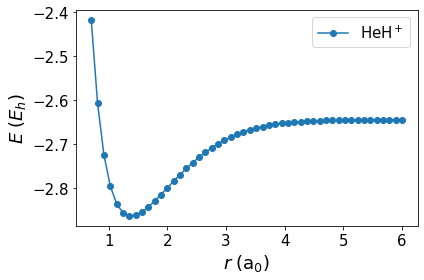

In [136]:
# let's plot it with some matplotlib! 
import matplotlib.pyplot as plt
%matplotlib inline
fig, ax = plt.subplots()

ax.plot(rvals, evals, '-o', label='HeH$^+$')
ax.set_xlabel(r'$r\;(\mathrm{a}_0)$',fontsize=18)
ax.set_ylabel(r'$E\;(E_h)$',fontsize=18)
ax.tick_params(labelsize=15)
ax.legend(fontsize=15)
plt.tight_layout()
plt.show()

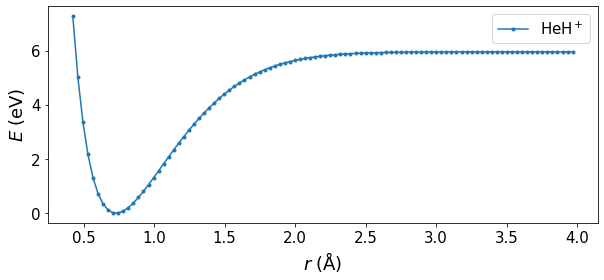

In [134]:
rvals = linspace(0.8, 7.5, 100)
evals = zeros(len(rvals))

for idx, i in enumerate(rvals):
    evals[idx] = scf_run(i, 2.0, 1.0, 2.0925, 1.24)

evals -= evals.min()
evals *= au2eV
rvals *= bohr2ang
fig, ax = plt.subplots(figsize=(8.5,4))
ax.plot(rvals, evals, '-o', ms=3, label='HeH$^+$')
ax.set_xlabel(r'$r\;(\mathrm{\AA})$', fontsize=18)
ax.set_ylabel(r'$E\;(\mathrm{eV})$', fontsize=18)
ax.tick_params(labelsize=15)
ax.legend(fontsize=15)
plt.tight_layout()
plt.show()

Wow, that's one good looking PES curve you got there kid!

Slap that in a presentation and you'll be a quantum chemist in no time!

## DIIS (Optional) 
Direct inversion of the iterative subspace or the Pulay equation 

Ever wonder what that `DIIS` stuff is all about? Regardless of your answer, you're going to find out.

We'll first write a function that performs the DIIS extrapolation to generate a new solution vector.

Recall the steps for the DIIS-accelerated algorithm
#### DIIS within a generic SCF Iteration
1. Compute $\mathbf{F}$, append to list of previous trial vectors
2. Compute AO orbital gradient$\mathbf{r}$, append to list of previous residual vectors
3. Compute UHF/RHF energy
3. Check convergence criteria
    - If RMSD of **r** sufficiently small, and
    - If change in SCF energy sufficiently small, break
4. Build $\mathbf{B}$ matrix from previous AO gradient vectors
5. Solve Pulay equation for coefficients $\{c_i\}$
6. Compute DIIS solution vector `F_diis` from $\{c_i\}$ and previous trial vectors
7. Compute new orbital guess with `F_diis`

In our function, we will perform steps 4-6 of the above algorithm.  What information will we need to provide our function in order to do so?  To build $\mathbf{B}$ (step 4 above) in the previous tutorial, we used:
~~~python
# Build B matrix
B_dim = len(F_list) + 1
B = empty((B_dim, B_dim))
B[-1,:] = -1
B[:, -1] = -1
B[-1, -1] = 0
for i in range(len(F_list)):
    for j in range(len(F_list)):
        B[i,j] = sum(diis_resid[i]*diis_resid[j])
~~~
We must have all previous DIIS residual vectors (`diis_resid`), as well how many previous trial vectors there are (for the dimension of $\mathbf{B}$).

To solve the Pulay equation (step 5 above):
~~~python
# Build RHS of Pulay equation 
rhs = zeros((B_dim))
rhs[-1] = -1 
      
# Solve Pulay equation for c_i's with NumPy solve routine
coeff = linalg.solve(B, rhs)
~~~
For this step, we only need the dimension of $\mathbf{B}$ (which we computed in step 4 above) and the `linalg.solve` routine from numpy/scipy, so this step doesn't require any additional arguments.  Finally, to build the DIIS Fock matrix (step 6):
~~~python
# Build DIIS Fock matrix
F_diis = zeros_like(F_list[0])
for ix in range(coeff.shape[0] - 1):
    F_diis += coeff[ix]*F_list[ix]
return F_diis
~~~
For this step, we need to know all the previous trial vectors (`F_list`) and the coefficients generated in the previous step. In the cell below, we'll write a funciton `diis_extrap()` according to the diis procedure, steps 4-6, with the above code snippets. We are essentially taking a previous list of trial vectors, `F_list` and residual vectors `diis_resid`and returning the new DIIS solution vector `F_diis`. 

In [59]:
def diis_extrap(F_list, diis_resid):
    B_dim = len(F_list) + 1
    B = empty((B_dim, B_dim))
    B[-1,:] = -1
    
    B[ :,-1] = -1
    B[-1,-1] =  0
    
    for i in range(len(F_list)):
        for j in range(len(F_list)):
            B[i,j] = sum(diis_resid[i]*diis_resid[j])
            
    rhs = zeros((B_dim))
    rhs[-1] = -1 
    coeff = linalg.solve(B, rhs)
    
    F_diis = zeros_like(F_list[0])
    for ix in range(coeff.shape[0] - 1):
        F_diis += coeff[ix]*F_list[ix]
    
    return F_diis

Now, let's throw this into our SCF routine, and see what it is cabable of. Let's also define some additional convergence criteria as well, based on the change in energy and our DIIS vector. 

In [60]:
MaxIt = 25

# convergence of the dRMS
D_conv = 1.0e-3
# convergence of the energy 
E_conv = 1.0e-5

E_old = 0.0 
# create empty lists for the diis 
F_list = []
R_list = [] 
diis_resid = [] 

nocc = 1
C, P, epsilon = diag_F(Hmat, nocc)

for scf_iter in range(MaxIt):
    
    F = Hmat + formG(P)
    # form this intermediate M for the sake of readability
    M = dot(F, dot(P, Smat)) - dot(Smat, dot(P, F))
    diis_r = dot(X, dot(M, X))
    # append F and diis_r to lists
    F_list.append(F)
    R_list.append(diis_r)
    
    ET = sum(P*(Hmat + F)) + E_nuc

    C, P, epsilon = diag_F(F, nocc)
    
    if scf_iter >= 2:
        F = diis_extrap(F_list, R_list)
        
    dE = ET - E_old
    dRMS = sqrt(mean(diis_r**2))
    
    print('SCF Iteration {:2d}: Energy = {: 4.12f} dE = {: 1.5e} dRMS = {:1.5e}'.format(scf_iter+1, ET, dE, dRMS))
    
    if (abs(dE) < E_conv) and (dRMS < D_conv):
        break
    
    E_old = ET

# print the energies to the screen 
diis_energy = ET
print('\nTotal SCF Energy   = {: .12f}'.format(ET))

SCF Iteration  1: Energy = -2.774995735620 dE = -2.77500e+00 dRMS = 1.79682e-01
SCF Iteration  2: Energy = -2.859624758615 dE = -8.46290e-02 dRMS = 2.13677e-02
SCF Iteration  3: Energy = -2.860655784830 dE = -1.03103e-03 dRMS = 1.68539e-03
SCF Iteration  4: Energy = -2.860662127586 dE = -6.34276e-06 dRMS = 1.26875e-04

Total SCF Energy   = -2.860662127586


Check to see if this result is the same as the previous

In [61]:
allclose(diis_energy, canon_energy)

True

Wow! We saved 0 steps! The savings are not yet evident, this is after all a two electron system. But trust me and trust literature too, diis helps. 

---